## Import libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor

In [4]:
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# DL (Keras MLP)
HAS_TF = False
try:
    import tensorflow as tf
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    HAS_TF = True
except Exception:
    HAS_TF = False

### Assest Selection

In [5]:
tickers = "AAPL"

In [6]:
period = "5y"
interval = "1d"

In [7]:
data = yf.download(tickers, period=period, interval=interval, auto_adjust=False, progress=False, threads=True)
if isinstance(data.columns, pd.MultiIndex):
    panels = []
    for col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
        if col in data.columns.get_level_values(0):
            tmp = data[col].copy()
            tmp.columns.name = "Ticker"
            tmp = tmp.stack().rename(col)
            panels.append(tmp)
    df = pd.concat(panels, axis=1).reset_index().rename(columns={"Date": "Date"})
else:
    df = data.reset_index()
    df["Ticker"] = tickers if isinstance(tickers, str) else tickers[0]
df = df.dropna().sort_values(["Ticker", "Date"])
df.head()

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
0,2020-09-03,AAPL,126.910004,128.839996,120.500000,120.879997,117.582130,257599600
1,2020-09-04,AAPL,120.070000,123.699997,110.889999,120.959999,117.659958,332607200
2,2020-09-08,AAPL,113.949997,118.989998,112.680000,112.820000,109.742004,231366600
3,2020-09-09,AAPL,117.260002,119.139999,115.260002,117.320000,114.119255,176940500
4,2020-09-10,AAPL,120.360001,120.500000,112.500000,113.489998,110.393730,182274400


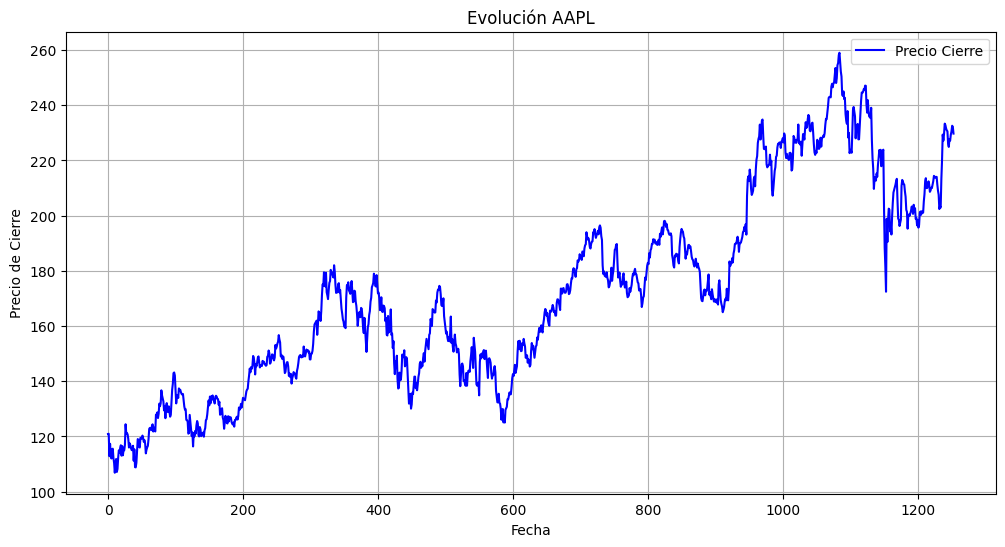

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label="Precio Cierre", color="blue")

plt.title("Evolución AAPL")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)
plt.show()

## Functions

In [ ]:
#Exponential Moving Average (EMA)
def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

In [ ]:
# The Relative Strength Index (RSI)
def rsi(close, window=14):
    delta = close.diff()
    up = delta.clip(lower=0.0)
    down = -delta.clip(upper=0.0)
    roll_up = up.ewm(alpha=1/window, adjust=False).mean()
    roll_down = down.ewm(alpha=1/window, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-12)
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
# Moving average convergence divergence (MACD)
def macd(close, fast=12, slow=26, signal=9):
    macd_line = ema(close, fast) - ema(close, slow)
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

In [ ]:
#Average True Range (ATR)
def atr(high, low, close, window=14):
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(window).mean()

## Calculating

In [46]:
a,b,c = macd(df["Close"])

In [47]:
d = atr(df["High"], df["Low"], df["Close"])

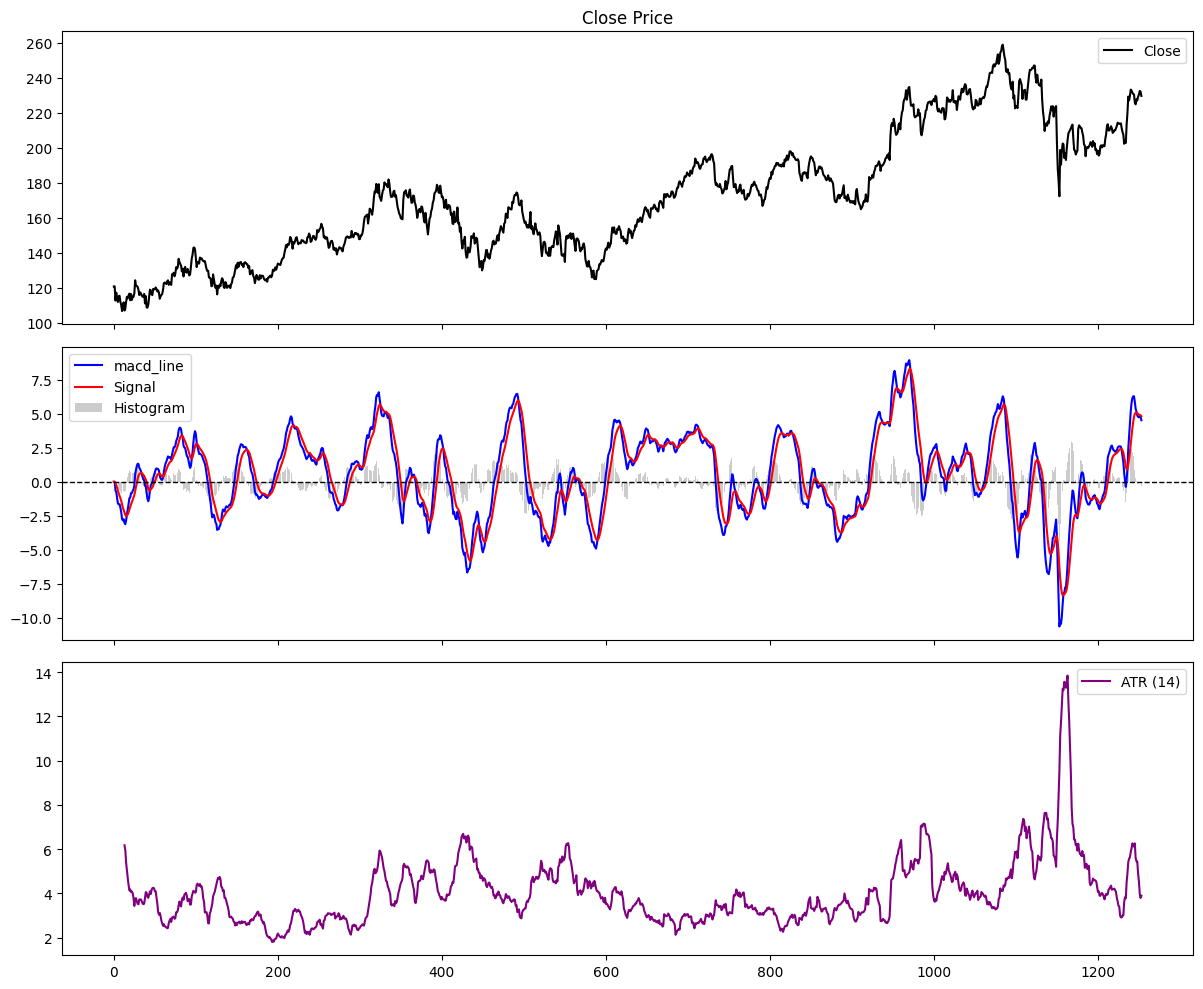

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Precio
ax1.plot(df.index, df["Close"], label="Close", color="black")
ax1.set_title("Close Price")
ax1.legend()

# AAPL
ax2.plot(a.index, a, label="macd_line", color="blue")
ax2.plot(b.index, b, label="Signal", color="red")
ax2.bar(c.index, c, label="Histogram", color="gray", alpha=0.4)
ax2.axhline(0, color="black", linewidth=1, linestyle="--")
ax2.legend()

# ATR
ax3.plot(d.index, d, label="ATR (14)", color="purple")
ax3.legend()

plt.tight_layout()
plt.show()

## Ploting  rsi closing

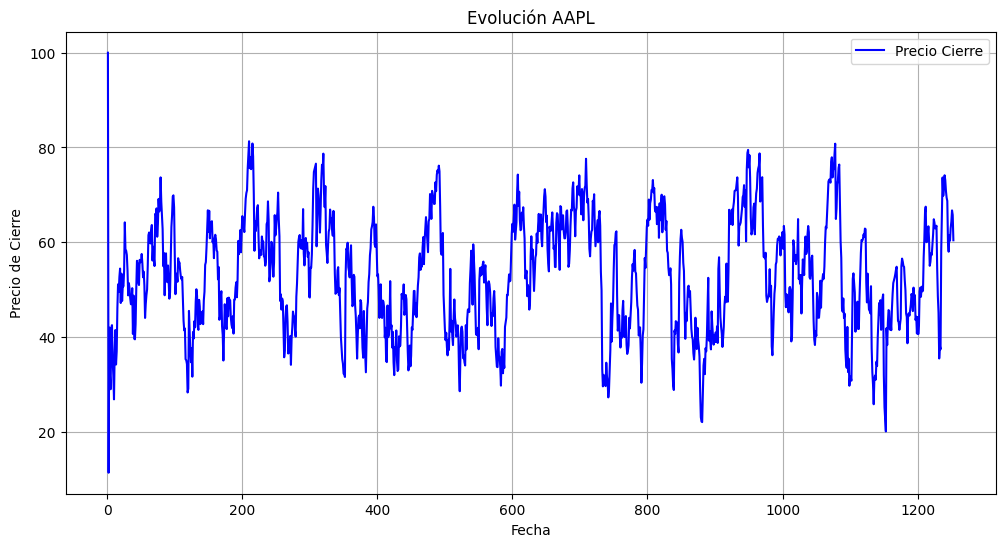

In [23]:
plt.figure(figsize=(12,6))
plt.plot(rsi.index, rsi, label="Precio Cierre", color="blue")

plt.title("Evolución AAPL")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend()
plt.grid(True)
plt.show()

## Building features

In [35]:
def build_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["ret1"] = out["Close"].pct_change()
    out["logret1"] = np.log1p(out["ret1"])

    # Medias y momentum
    for w in [5, 10, 20, 50, 100]:
        out[f"sma{w}"] = out["Close"].rolling(w).mean()
        out[f"ema{w}"] = ema(out["Close"], w)
        out[f"mom{w}"] = out["Close"] / out["Close"].shift(w) - 1

    # Volatilidad
    out["vol5"] = out["ret1"].rolling(5).std()
    out["vol20"] = out["ret1"].rolling(20).std()

    # RSI y MACD
    out["rsi14"] = rsi(out["Close"], 14)
    out["macd"], out["macd_sig"], out["macd_hist"] = macd(out["Close"])

    # ATR
    out["atr14"] = atr(out["High"], out["Low"], out["Close"])

    # Relación precio/medias
    out["px_sma20"] = out["Close"] / out["sma20"] - 1
    out["px_sma50"] = out["Close"] / out["sma50"] - 1

    out = out.dropna().copy()
    return out

In [43]:
df_feat = build_features(df)
df_feat

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,ret1,logret1,...,mom100,vol5,vol20,rsi14,macd,macd_sig,macd_hist,atr14,px_sma20,px_sma50
100,2021-01-28,AAPL,139.520004,141.990005,136.699997,137.089996,133.579926,142621100,-0.034985,-0.035612,...,0.134100,0.024026,0.022044,57.222685,3.514628,2.775004,0.739624,4.059288,0.029919,0.075972
101,2021-01-29,AAPL,135.830002,136.740005,130.210007,131.960007,128.581299,177523800,-0.037421,-0.038139,...,0.090939,0.027101,0.023596,49.027227,2.901910,2.800385,0.101525,4.379287,-0.007965,0.033816
102,2021-02-01,AAPL,133.750000,135.380005,130.929993,134.139999,130.705475,106239800,0.016520,0.016385,...,0.188974,0.023415,0.023822,52.162645,2.562693,2.752847,-0.190154,4.443573,0.007874,0.048472
103,2021-02-02,AAPL,135.729996,136.309998,134.610001,134.990005,131.533737,83305400,0.006337,0.006317,...,0.150614,0.024193,0.023071,53.367128,2.335526,2.669383,-0.333857,4.396430,0.012139,0.052326
104,2021-02-03,AAPL,135.759995,135.770004,133.610001,133.940002,130.510605,89880900,-0.007778,-0.007809,...,0.180192,0.024190,0.023051,51.637502,2.047170,2.544940,-0.497770,4.339288,0.003164,0.041655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,2025-08-26,AAPL,226.869995,229.490005,224.690002,229.309998,229.309998,54575100,0.009465,0.009420,...,0.024208,0.012909,0.019226,62.955383,4.777840,4.994101,-0.216260,4.897143,0.033156,0.074270
1250,2025-08-27,AAPL,228.610001,230.899994,228.259995,230.490005,230.490005,31259500,0.005146,0.005133,...,0.134357,0.007592,0.018908,64.347137,4.738256,4.942932,-0.204675,4.542856,0.033481,0.076563
1251,2025-08-28,AAPL,230.820007,233.410004,229.339996,232.559998,232.559998,38074700,0.008981,0.008941,...,0.234526,0.005886,0.018705,66.709904,4.818374,4.918020,-0.099646,3.994286,0.036953,0.082498
1252,2025-08-29,AAPL,232.509995,233.380005,231.369995,232.139999,232.139999,39389400,-0.001806,-0.001808,...,0.279290,0.005778,0.017361,65.757686,4.792729,4.892962,-0.100233,3.795000,0.028258,0.076978


In [32]:
def build_ml_models(random_state=42, input_dim=None, dl_epochs=20, dl_batch=64):
    models = {}
    rf = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("rf", RandomForestRegressor(n_estimators=400, max_depth=6, random_state=random_state, n_jobs=-1))
    ])
    models["rf"] = rf

    if HAS_XGB:
        xgb = Pipeline([
            ("scaler", StandardScaler(with_mean=False)),
            ("xgb", XGBRegressor(
                n_estimators=700,
                max_depth=6,
                learning_rate=0.035,
                subsample=0.85,
                colsample_bytree=0.85,
                objective="reg:squarederror",
                random_state=random_state,
                n_jobs=-1
            ))
        ])
        models["xgb"] = xgb
    else:
        gbr = Pipeline([
            ("scaler", StandardScaler(with_mean=False)),
            ("gbr", GradientBoostingRegressor(random_state=random_state))
        ])
        models["gbr"] = gbr

    if HAS_TF and input_dim is not None:
        def build_mlp():
            m = Sequential([
                Dense(128, activation="relu", input_shape=(input_dim,)),
                Dropout(0.25),
                Dense(64, activation="relu"),
                Dropout(0.25),
                Dense(1, activation="linear")
            ])
            m.compile(optimizer="adam", loss="mse")
            return m
        models["dl_mlp_builder"] = build_mlp
        models["dl_params"] = {"epochs": dl_epochs, "batch_size": dl_batch}
    return models

In [33]:
def time_series_cv_train(X, feature_cols, cfg):
    tscv = TimeSeriesSplit(n_splits=cfg["model"]["test_splits"])
    rows = []
    fold_metrics = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        train = X.iloc[train_idx].copy()
        test = X.iloc[test_idx].copy()

        y_train = train["target"].values
        y_test = test["target"].values

        ml_models = build_ml_models(
            random_state=cfg["model"]["random_state"],
            input_dim=len(feature_cols),
            dl_epochs=cfg["model"]["dl_epochs"],
            dl_batch=cfg["model"]["dl_batch_size"]
        )

        fitted = {}
        for name, model in ml_models.items():
            if name in ["dl_mlp_builder", "dl_params"]:
                continue
            model.fit(train[feature_cols].values, y_train)
            fitted[name] = model

        if "dl_mlp_builder" in ml_models:
            dl = ml_models["dl_mlp_builder"]()
            es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
            dl.fit(train[feature_cols].values, y_train,
                   validation_split=0.2,
                   epochs=ml_models["dl_params"]["epochs"],
                   batch_size=ml_models["dl_params"]["batch_size"],
                   verbose=0,
                   callbacks=[es])
            fitted["dl_mlp"] = dl

        parts = []
        for name, model in fitted.items():
            if name == "dl_mlp":
                p = model.predict(test[feature_cols].values, verbose=0).flatten()
            else:
                p = model.predict(test[feature_cols].values)
            parts.append(p)
        y_pred = np.mean(np.vstack(parts), axis=0)

        tmp = test[["Date", "Ticker", "target"]].copy()
        tmp["y_pred"] = y_pred
        tmp = tmp.rename(columns={"target": "y_true"})
        rows.append(tmp)

        corr = np.corrcoef(y_test, y_pred)[0,1] if len(y_test) > 3 else np.nan
        mae = np.mean(np.abs(y_test - y_pred))
        fold_metrics.append({"fold": fold+1, "corr": float(corr), "mae": float(mae)})

    cv_pred_df = pd.concat(rows, axis=0).sort_values("Date").reset_index(drop=True)
    return cv_pred_df, fold_metrics

In [35]:
feature_cols = [c for c in X.columns if c not in ["Date", "Ticker", "Open", "High", "Low", "Close", "Adj Close", "Volume", "target"]]

In [39]:
result = time_series_cv_train(X, feature_cols, {
    "model": {
        "test_splits": 5,
        "random_state": 42,
        "dl_epochs": 50,
        "dl_batch_size": 32
    }
})

In [41]:
result[0]

,Date,Ticker,y_true,y_pred
0,2023-03-31,AAPL,0.007702,0.010779
1,2023-04-03,AAPL,-0.003250,0.001129
2,2023-04-04,AAPL,-0.011290,0.001327
3,2023-04-05,AAPL,0.005496,0.019470
4,2023-04-06,AAPL,-0.015972,0.007016
...,...,...,...,...
595,2025-08-15,AAPL,-0.003023,-0.004022
596,2025-08-18,AAPL,-0.001429,-0.002755
597,2025-08-19,AAPL,-0.019735,0.004673
598,2025-08-20,AAPL,-0.004911,-0.000424


In [43]:
df_2 = result[0]

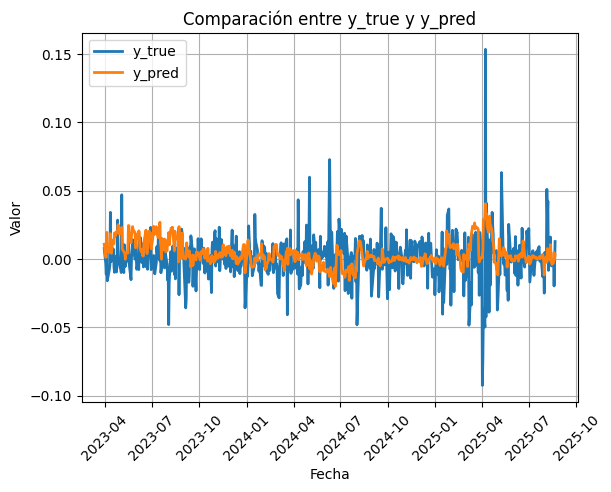

In [44]:
# Graficar curva real
plt.plot(df_2["Date"], df_2["y_true"], label="y_true", linewidth=2)

# Graficar curva predicha
plt.plot(df_2["Date"], df_2["y_pred"], label="y_pred", linewidth=2)

# Decoración del gráfico
plt.title("Comparación entre y_true y y_pred")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()